<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
!pip install Ta-Lib

In [ ]:
pip install Ta-Lib -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
pip install git+https://github.com/quantopian/pyfolio

In [ ]:
## install finrl library
!pip install wrds -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install swig -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git 


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
import torch
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
# matplotlib.use('Agg')
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
#from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_add import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../mha-gru-drl")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [6]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2021-02-28'

In [5]:
TRAIN_START_DATE = '2015-10-10'
TRAIN_END_DATE = '2021-02-28'
TRADE_START_DATE = '2021-03-01'
TRADE_END_DATE = '2022-02-28'


In [7]:
import tushare as ts
ts.set_token('6314756019e50a6672690e5a78b2dbf7cfcd27c6f6a6b48a8cf76dae')
pro = ts.pro_api()

In [8]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20121010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [ ]:
df_index

In [9]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20200228' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['603993.SH' '603259.SH' '601989.SH' '601988.SH' '601939.SH' '601888.SH'
 '601857.SH' '601818.SH' '601766.SH' '601688.SH' '601668.SH' '601628.SH'
 '601601.SH' '601398.SH' '601390.SH' '601336.SH' '601328.SH' '601319.SH'
 '601318.SH' '601288.SH' '601236.SH' '601211.SH' '601186.SH' '601166.SH'
 '601138.SH' '601111.SH' '601088.SH' '601066.SH' '601012.SH' '600887.SH'
 '600837.SH' '600703.SH' '600690.SH' '600585.SH' '600547.SH' '600519.SH'
 '600340.SH' '600309.SH' '600276.SH' '600196.SH' '600104.SH' '600050.SH'
 '600048.SH' '600036.SH' '600031.SH' '600030.SH' '600028.SH' '600016.SH'
 '600009.SH' '600000.SH'] 50


In [10]:
#随机选择成分股中的k只股票
import random 
k = 8
selected_tics = random.sample(list(sort_SSEindex),k)
print(selected_tics)

['601138.SH', '601336.SH', '600104.SH', '600547.SH', '600837.SH', '601211.SH', '600887.SH', '600340.SH']


In [ ]:
#如果选择从config中配置可以用这段代码快速更改后缀
# new = []
# for c in config_tickers.SSE_50_TICKER:
#     c = c.replace('XSHG','SH')
#     new.append(c)
# print(new,len(new))

In [11]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date=TRAIN_START_DATE,end_date=TRADE_END_DATE)
    df_ts=pd.concat([df_ts,temp])
print(df_ts)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     601138.SH   20211231  11.92  11.95  11.78  11.92      11.90    0.02   
1     601138.SH   20211230  11.91  11.98  11.86  11.90      11.90    0.00   
2     601138.SH   20211229  12.00  12.05  11.84  11.90      12.05   -0.15   
3     601138.SH   20211228  12.08  12.10  11.96  12.05      12.08   -0.03   
4     601138.SH   20211227  11.98  12.12  11.96  12.08      11.98    0.10   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1668  600340.SH   20150109  41.92  46.00  41.81  43.32      42.00    1.32   
1669  600340.SH   20150108  42.62  42.84  41.30  42.00      42.62   -0.62   
1670  600340.SH   20150107  41.80  43.20  41.13  42.62      42.67   -0.05   
1671  600340.SH   20150106  44.00  44.08  41.00  42.67      44.76   -2.09   
1672  600340.SH   20150105  43.50  46.78  43.50  44.76      43.60    1.16   

      pct_chg        vol       amount  
0      0.1681  227339.87   269934.9

In [ ]:
df_ts.to_csv('20_test_626',index=None)

In [ ]:
max_len = max(df_ts['ts_code'].value_counts())

In [ ]:
# #检验50只股票的信息缺省的时间点和个数
# dimatch_num = 0
# dimatch_date =[]
# for c in df_ts1['trade_date'].unique():
#     temp = df_ts1[df_ts1['trade_date'] == c]
#     if len(temp) != 50:
#         dimatch_num +=1
#         dimatch_date.append(c)
# print(dimatch_num,dimatch_date)

In [ ]:
# #获取SSE的交易日历
# import exchange_calendars as tc
# def get_trading_days(exchange: str, start_date: str, end_date: str):
#     days = pro.trade_cal(exchange=exchange, start_date=start_date, end_date=end_date)
#     days = days[days['is_open'] == 1]
#     full_date_range = pd.DataFrame({'trade_date':days['cal_date']})
#     full_date_range['trade_date'] = full_date_range['trade_date'].astype(str)
#     return full_date_range

# full_date_range = get_trading_days(exchange='SSE',start_date='20121010', end_date='20230228')
# print(full_date_range)

In [ ]:
# date_unique = df['date'].unique()
# date_sum = len(date_unique)
# count = 0
# for date in date_unique:
#     temp_df = df[df['trade_date'] == date]
# #     if len(temp_df) = k:
# #         count +=1
# #     elif len(temp_df) < int(0.9*k):
# #         date_unique.remove(date)
# #     else:
#     difference_tic = temp_df['ts_code'].tolist().difference(selected_tics)
#     missing_tic.append(date,difference_tic)

In [ ]:
# #遍历扩充股票的完整交易日期
# def add_exchange_calendars(df,full_date_range,selected_tics):
#     merge_df = []
#     for tic in selected_tics:
#         temp_df = df[df['ts_code'] == tic]
#         temp_full_date_range = full_date_range
#         temp_df = temp_df.set_index('trade_date')
#         temp_full_date_range = temp_full_date_range.set_index('trade_date')
#         temp_df = pd.merge(temp_full_date_range,temp_df,how='left',left_index=True,right_index=True)
#         temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
#         temp_df = temp_df.fillna({
#             'amount' : 0,
#             'vol': 0,
#             'pct_chg': 0,
#             'change':0,
#             'ts_code': tic
#         })
#         for i in range(len(temp_df)):
#             if pd.isna(temp_df.loc[i,'close']):
#                 j = i -1
#                 while pd.isna(temp_df.loc[j,'close']):
#                     j = j - 1
#                 if j > 0 :
#                     temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
#         merge_df.append(temp_df)
#     merged_df = pd.concat(merge_df,ignore_index = True)
#     return merged_df

# merged_df =  add_exchange_calendars(df_ts,full_date_range,selected_tics)
# merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# print(merged_df)

In [ ]:
# 筛选exchange_calender中每个交易节点缺失情况
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) < int(0.9*k):
            date_unique.remove(date)
        elif len(temp_df) >= int(0.9*k) and len(temp_df) < k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
            print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':np.nan, 'high':np.nan,'low':np.nan, 'close':np.nan, 'pre_close':np.nan, 'change':np.nan, 'pct_chg':np.nan, 'volume':np.nan, 'amount':np.nan}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
#             print(len(temp_df))
            processe_df.append(temp_df)
        else :
            count += 1
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique


In [12]:
# 筛选exchange_calender中每个交易节点缺失情况(全部补充0)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) != k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
#             print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':0, 'high':0,'low':0, 'close':0, 'pre_close':0, 'change':0, 'pct_chg':0, 'volume':0, 'amount':0}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
            processe_df.append(temp_df)
        else :
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique

In [ ]:
# 筛选exchange_calender中每个交易节点缺失(激进)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) == k:
            processe_df.append(temp_df)
        else :
            date_unique.remove(date)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique
        

In [13]:
processed_df,date_unique = processed_date(df_ts,selected_tics,k)
print(processed_df) 

         ts_code trade_date   open   high    low  close pre_close change  \
0      601138.SH   20150105      0      0      0      0         0      0   
1      601336.SH   20150105  50.35  51.95  49.05  49.61     49.56   0.05   
2      600104.SH   20150105   21.7  23.62  21.69  23.62     21.47   2.15   
3      600547.SH   20150105  19.86  21.51  19.65   21.3     19.85   1.45   
4      601211.SH   20150105      0      0      0      0         0      0   
...          ...        ...    ...    ...    ...    ...       ...    ...   
13635  600837.SH   20211231  12.29  12.33  12.24  12.26     12.23   0.03   
13636  600547.SH   20211231   18.7  18.87  18.65  18.82     18.59   0.23   
13637  600104.SH   20211231  20.56   20.7  20.54  20.63     20.53    0.1   
13638  601336.SH   20211231  38.88  39.02  38.77  38.88     38.88    0.0   
13639  601138.SH   20211231  11.92  11.95  11.78  11.92      11.9   0.02   

      pct_chg         vol       amount volume  
0           0         NaN            0 

In [14]:
processed_df1 = processed_df.drop('volume',axis=1)
processed_df1 = processed_df1.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
processed_df1['trade_date'] = pd.to_datetime(processed_df1['trade_date'])
processed_df1

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600104.SH,2015-01-05,21.7,23.62,21.69,23.62,21.47,2.15,10.01,1308210.72,3010419.454
1,600104.SH,2015-01-06,23.6,25.98,23.19,24.67,23.62,1.05,4.45,1437856.69,3565284.301
2,600104.SH,2015-01-07,24.6,25.2,24.0,24.66,24.67,-0.01,-0.04,740619.55,1810192.875
3,600104.SH,2015-01-08,24.36,24.66,23.6,24.14,24.66,-0.52,-2.11,552735.65,1330823.119
4,600104.SH,2015-01-09,23.97,24.65,23.57,23.74,24.14,-0.4,-1.66,675712.22,1624807.304
...,...,...,...,...,...,...,...,...,...,...,...
13635,601336.SH,2021-12-27,38.49,38.7,38.43,38.54,38.45,0.09,0.2341,43263.70,166749.378
13636,601336.SH,2021-12-28,38.56,39.18,38.56,38.9,38.54,0.36,0.9341,70283.88,273433.897
13637,601336.SH,2021-12-29,39.0,39.1,38.7,38.84,38.9,-0.06,-0.1542,44263.29,172034.789
13638,601336.SH,2021-12-30,38.84,39.08,38.72,38.88,38.84,0.04,0.103,46751.88,181813.957


In [15]:
def delaydate(dela,full_list):
    grouped = processed_df1.groupby('ts_code')
    filtered_df = pd.DataFrame()
    for name, group in grouped:
        # 按'trade_date'升序排序  True=升序
        group = group.sort_values('trade_date', ascending=True)
        
        # 丢弃前48个日期的数据
        group = group.iloc[dela:]
        filtered_df = filtered_df.append(group)
    
    filtered_df = filtered_df.reset_index(drop=True)
    filtered_df = filtered_df.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
    return filtered_df

In [ ]:
#对于第二次任务训练任务—————强化学习决策任务
import datetime

start_date = datetime.datetime.strptime(TRAIN_START_DATE, '%Y-%m-%d')
timestep = datetime.timedelta(days=48) # 这里需要验证48是否是已有数据往前推，还是只在时间维度向前推48天，可能会存在不足48天数据的情况。
target_date = start_date - timestep
train_df = processed_df1[processed_df1['trade_date'] <= TRAIN_END_DATE]
backtest_df = processed_df1[(processed_df1['trade_date'] >= target_date) & (processed_df1['trade_date'] <= TRADE_END_DATE)]
print('target_date:',target_date,'train_df:',train_df,'backtest_df:',backtest_df)


In [16]:
# feature_enginner
alltic_list = [i for i in range(k)]

def Feature_enginner(model, processed_df, full_list, alltic_list, batch_size=64, k=15, env_size=40,dela = 48):
    back_iter = DataLoader(StockDataset_back([i for i in range(k)],full_list), shuffle=False, batch_size=batch_size, num_workers=0,drop_last=False)
    
    new_state = predict(model,back_iter)
    concatenated_tensor = torch.cat(new_state, dim=0)
    concatenated_tensor = concatenated_tensor.view(-1,env_size)
    feature_df = pd.DataFrame(concatenated_tensor.numpy())
    
    full_delay_df = delaydate(dela ,processed_df)
    
    merged_df = pd.concat([full_delay_df, feature_df], axis=1)
    merged_df = merged_df.loc[:,['ts_code','trade_date','close']+[i for i in range(env_size)]]
    merged_df.columns = ['tic','date','close'] + [f"temporal_feature_{i}" for i in range(env_size)]
    return merged_df

In [36]:
addfeature_df = Feature_enginner(model, processed_df1, array_full_list, alltic_list, batch_size=64, k=8 ,env_size=40, dela=48)

In [37]:
addfeature_df

,tic,date,close,temporal_feature_0,temporal_feature_1,temporal_feature_2,temporal_feature_3,temporal_feature_4,temporal_feature_5,temporal_feature_6,...,temporal_feature_30,temporal_feature_31,temporal_feature_32,temporal_feature_33,temporal_feature_34,temporal_feature_35,temporal_feature_36,temporal_feature_37,temporal_feature_38,temporal_feature_39
0,600104.SH,2015-03-19,24.71,-0.685629,-0.720051,-0.788440,1.056978,-0.217109,-0.065294,0.021171,...,1.137640,0.067500,1.152653,0.970156,-1.672183,-0.859973,-1.091588,0.064175,-0.307347,-1.024077
1,600104.SH,2015-03-20,24.71,-0.825145,-0.539233,-0.869592,0.946963,-0.180360,-0.060116,0.020285,...,1.019768,-0.051935,1.147488,0.778445,-1.668119,-1.051902,-1.016064,-0.007655,-0.239199,-1.035237
2,600104.SH,2015-03-23,25.46,-1.021337,-0.601413,-0.962846,1.141143,-0.106581,0.013600,0.044698,...,0.852832,-0.089386,1.299286,0.788713,-1.529159,-1.093202,-1.042035,-0.077120,-0.033720,-1.034090
3,600104.SH,2015-03-24,25.51,-0.737324,-0.772424,-0.895961,1.496457,-0.376672,-0.268712,0.364131,...,1.195056,0.045877,1.392800,0.960066,-1.599501,-0.912930,-1.072493,0.196815,-0.099987,-1.009710
4,600104.SH,2015-03-25,24.79,-0.875907,-0.863073,-0.933658,1.356204,-0.330987,-0.410442,0.145461,...,1.044580,0.034205,1.417628,0.708407,-1.651163,-0.776831,-1.071662,0.074468,-0.438858,-0.856375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13251,601336.SH,2021-12-27,38.54,0.967883,0.870768,-0.368305,-0.053448,1.435534,-0.050873,-0.769674,...,0.612730,-0.146083,0.782575,-0.706725,-1.159345,-0.813882,-0.986079,-1.687930,1.059072,-0.211687
13252,601336.SH,2021-12-28,38.9,1.019005,0.868325,-0.444494,0.130799,1.499849,-0.080379,-0.744683,...,0.595876,-0.133265,0.882290,-0.681690,-1.019547,-0.795075,-0.976471,-1.661369,1.111718,-0.207583
13253,601336.SH,2021-12-29,38.84,1.123853,0.184553,-0.667018,0.427636,1.551040,-0.046267,-0.892855,...,0.443955,-0.020844,0.528153,-0.784706,-1.263101,-0.901676,-0.808549,-1.317476,0.597605,-0.103068
13254,601336.SH,2021-12-30,38.88,0.971723,-0.194115,-0.656207,0.508096,1.469427,-0.091287,-0.875409,...,0.283373,-0.093154,0.344909,-0.710574,-1.420322,-0.816872,-0.790407,-1.290575,0.291341,0.117479


In [ ]:
# reduction
# processed_df1['trade_date'] = pd.to_datetime(processed_df1['trade_date'],format='%Y%m%d')
tic_date_df =processed_df1.iloc[:,:2]
date_unique = len(tic_date_df['trade_date'].unique())
train_df_reduction = processed_df1.loc[:,['open','high','low','close','vol']]
train_df_reduction = processed_df1.reset_index(drop=True)
# backtest_df_reduction = backtest_df.loc[:,['open','high','low','close','vol']]
# backtest_df_reduction = backtest_df_reduction.reset_index(drop=True)
train_df_reduction = train_df_reduction.fillna(0)
# backtest_df_reduction = backtest_df_reduction.fillna(0)
pro_df = train_df_reduction

In [17]:
pro_df = processed_df1.loc[:,['open','high','low','close','vol']].reset_index(drop=True)

In [ ]:
pro_df

In [ ]:
#出现缺失值的个数、占比
count = len(pro_df[pro_df['open'] == 0])
nan_rate = count/len(pro_df)
print(count,'缺失值百分之:',nan_rate)

In [18]:
#计算技术指标到dataset中
#Can be easily expanded
#Currently contains a small set of tech indicators
import talib as ta

def calc_tech_ind(data):
    #overlap 
    data['upbd'], data['midbd'], data['lowbd'] = ta.BBANDS(data["close"])
    data['dema'] = ta.DEMA(data["close"], timeperiod=30)
    data['tema'] = ta.TEMA(data["close"], timeperiod=30)
    data['ema'] = ta.EMA(data["close"], timeperiod=30)
    data['wma'] = ta.WMA(data["close"], timeperiod=30)
    data['sma'] = ta.SMA(data["close"], timeperiod=30)
    data['sarext'] = ta.SAREXT(data["high"], data["low"])
    
    #momentum
    data['adxr'] = ta.ADXR(data["high"], data["low"], data["close"], timeperiod=14)
    data['apo'] = ta.APO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['aroondown'], data['aroonup'] = ta.AROON(data["high"], data["low"], timeperiod=14)
    data['cci'] = ta.CCI(data["high"], data["low"], data["close"], timeperiod=14)
    data['cmo'] = ta.CMO(data["close"], timeperiod=14)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data["close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MFI'] = ta.MFI(data["high"], data["low"], data["close"], data['vol'], timeperiod=14)
    data['mom'] = ta.MOM(data["close"], timeperiod=10)
    data['plus_di'] = ta.PLUS_DI(data["high"], data["low"], data["close"], timeperiod=14)
    data['ppo'] = ta.PPO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['roc'] = ta.ROC(data["close"], timeperiod=10)
    data['rocp'] = ta.ROCP(data["close"], timeperiod=10)
    data['rsi'] = ta.RSI(data["close"], timeperiod=14)
    data['slowk'], data['slowd'] = ta.STOCH(data["high"], data["low"], data["close"])
    data['fastk'], data['fastd'] = ta.STOCHF(data["high"], data["low"], data["close"])
    data['trix'] = ta.TRIX(data["close"], timeperiod=30)
    data['ultosc'] = ta.ULTOSC(data["high"], data["low"], data["close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    data['willr'] = ta.WILLR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #volume
    data['ad'] = ta.AD(data["high"], data["low"], data["close"], data['vol'])
    data['obv'] = ta.OBV(data["close"], data['vol'])
    
    #volitility
    data['atr'] = ta.ATR(data["high"], data["low"], data["close"], timeperiod=14)
    data['natr'] = ta.NATR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #cycle
    data['HT_DCPERIOD'] = ta.HT_DCPERIOD(data["close"])
#     data['HT_DCPHASE'] = ta.HT_DCPHASE(data["close"])
#     data['inphase'], data['quadrature'] = ta.HT_PHASOR(data["close"])
    
    
    return data

In [19]:
full_list1 = calc_tech_ind(pro_df)
full_list1 = full_list1.fillna(0)

In [ ]:
full_list1

In [ ]:
full_list2 = calc_tech_ind(backtest_df_reduction)
full_list2 = full_list2.fillna(0)

In [20]:
array_full_list = np.array(full_list1)
array_full_list = array_full_list.reshape(k,int(len(full_list1)/k),full_list1.shape[1])
selected_tics = sorted(selected_tics)

In [ ]:
array_full_list2 = np.array(full_list2)
array_full_list2 = array_full_list2.reshape(k,int(len(full_list2)/k),full_list2.shape[1])

In [ ]:
np.isnan(array_full_list).any()

In [ ]:
#text
# tdata = array_full_list[0][:-1]
ttdata = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
windows = 5
gap = 1
batch_size = 3
start = len(ttdata) - windows
test_list = []
while start >= 0:
#     print(ttdata[start:start + windows - 1],ttdata[start + windows-1])
    segdata = ttdata[start:start + windows]
#     segclose = ttdata[start:start + windows]
    test_list.extend([segdata] * batch_size)
#     test_list.append(segdata)
    start = start - gap
    print(test_list,'hhhhhhhhhhhhhhh',segdata)
    
# print(np.array(test_list)[::-1])

In [ ]:
# #generate x, y, z, zp quadruples
# #segment x, y, z trios to sequence according to $timeStep and $gap
# #x: historical data w/ technical analysis indicator
# #y: closing price of t+1
# #z:  difference between t+1 and t step's closing price

# def toSequential(idx, full_list, timeStep=48, gap=4):
#     #closing: from id=0 to last
#     closing=full_list[idx][:, 3]
#     #data from id=0 to second to last
#     data=full_list[idx][:-1]
#     #calculating number of available sequential samples
#     data_length=len(data)
#     count=(data_length-timeStep)//gap+1
#     stockSeq=[]
#     labelSeq=[]
#     diffSeq=[]
#     realDiffSeq=[]
    
#     start = data_length - timeStep
#     while start >= 0:
#         segData = data[start:start + timeStep - 1]
#         segClosing = closing[start:start + timeStep]
#         std_dev = segData.std(axis=0, keepdims=True)
#         std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
#         std_dev_close = segClosing.std()
#         std_dev_close_nonzero = np.where(std_dev_close == 0, 1, std_dev_close)
#         segClosingNorm=(segClosing-segClosing.mean())/std_dev_close_nonzero
#         stockSeq.append(segDataNorm)
#         labelSeq.append(segClosingNorm[1:])
# #         print(np.isnan(labelSeq).any())
#         diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
#         realDiffSeq.append(segClosing[1:]-segClosing[:-1])       
#         start = start - gap
#     stockSeq=np.array(stockSeq)[::-1]
#     labelSeq=np.array(labelSeq)[::-1]
#     diffSeq=np.array(diffSeq)[::-1]
#     realDiffSeq=np.array(realDiffSeq)[::-1]
    
#     return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

# Dataloader的构建

In [21]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train1(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
#     closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    for i in range(count):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closing[gap*i:gap*i+timeStep+1]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
    
        std_close = segClosing.std()
        std_segClosing = np.where(std_close == 0, 1, std_close)
        segClosingNorm=(segClosing-segClosing.mean())/std_segClosing
#         segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [ ]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[0,]
    realDiffSeq=[0,]
    for i in range(count-1):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closingNorm[gap*i+timeStep]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
#       segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
#       segClosingNorm=(segClosing-segClosing.mean())/segClosing.std()
        #segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosing)
        diffSeq.append(segClosing-diffSeq[-1])
        realDiffSeq.append(closing[gap*i+timeStep]-realDiffSeq[-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [22]:
def toSequential_back(idx, full_list, timeStep = 48, gap = 1,batch_size = 64):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    start = data_length - timeStep
    i=0
    while start >= 0:
        segData = data[start:start + timeStep]
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        #复制batch_size个
        stockSeq.extend([segDataNorm] * batch_size)
#         stockSeq.append(segDataNorm)   
        start = start - gap
        i +=1
    stockSeq=np.array(stockSeq)[::-1]
#     print(i)
    return stockSeq.astype('float32')

In [23]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=3):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        closing_cohort=[]
        diff_cohort=[]
        real_diff_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X, y, z, zp=toSequential_train1(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
            closing_cohort.append(y)
            diff_cohort.append(z)
            real_diff_cohort.append(zp)
        self.X=np.concatenate(stock_cohort, axis=0)
        self.y=np.concatenate(closing_cohort, axis=0)
        self.z=np.concatenate(diff_cohort, axis=0)  
        self.zp=np.concatenate(real_diff_cohort, axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        label1=self.y[idx]
        label2=self.z[idx]
        label3=self.zp[idx]
        if self.transform:
            data=self.transform(data)
        return (data, label1, label2, label3)
    
    
    def getDS(self):
        return self.X, self.y, self.z, self.zp

In [24]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset_back(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=1):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X=toSequential_back(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
        self.X=np.concatenate(stock_cohort, axis=0)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        if self.transform:
            data=self.transform(data)
        return data
        
    def getDS(self):
        return self.X

In [25]:
#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list, full_list, demo=False):
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    name_count=len(name_list)

    if demo:
        test_iter=DataLoader(StockDataset(test_id_list[0:1], full_list, timestep=24, gap=1), shuffle=False, batch_size=64, num_workers=0)
        print(f'Demo with stock: {name_list[test_id_list[0]]} ')
        return test_iter
    else:
        all_ids = list(range(name_count))
        train_id_list = list(set(all_ids) - set(test_id_list) - set(val_id_list))
#         partial_list=full_list[train_list,:,:]
        test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        val_iter=DataLoader(StockDataset(val_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        train_iter=DataLoader(StockDataset(train_id_list, full_list), shuffle=True, batch_size=64, num_workers=0,drop_last=True)
        print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {[name_list[train_id] for train_id in train_id_list]} ')
        return train_iter, val_iter, test_iter

In [26]:
train_iter, val_iter, test_iter = DataIterGen([3],[4],selected_tics,array_full_list)

Val: ['600887.SH'], Test: ['600837.SH'], Train: ['600104.SH', '600340.SH', '600547.SH', '601138.SH', '601211.SH', '601336.SH'] 


In [ ]:
len(array_full_list[0][0])

In [ ]:
for x,y,z,zp in train_iter: # x shape (bs,timestep,features); y、z、zp、shape(bs)
    print(len(y),x)

# Transformer

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_size, d_model, d_ff, num_heads,env_size, num_layers):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encode = Encoder(d_model, d_ff, num_heads, num_layers)
        self.linear1 = nn.Linear(d_model, env_size)
        self.rule = nn.ReLU()
        self.linear2 = nn.Linear(env_size,1)
        

    def forward(self, x):
        x = self.embedding(x)
#         print(x.shape)
        x = x.permute(1,0,2)
        encoded = self.encode(x)
        encoded = self.linear1(encoded)
        x = self.rule(encoded)
        x = self.linear2(x)
#         print(x.shape)
        decoded = x.permute(1,0,2)
        return decoded, encoded.permute(1,0,2)[0,-1,:]  


In [28]:
class Encoder(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, num_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, num_heads):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x  # 保存输入的残差连接

        # Self-Attention
        x, _ = self.self_attention(x, x, x)
        x = x + residual  # 残差连接
        x = self.norm1(x)  # Add & Norm

        residual = x  # 保存 Self-Attention 后的残差连接

        # Feed-Forward
        x = self.feed_forward(x)
        x = x + residual  # 残差连接
        x = self.norm2(x)  # Add & Norm

        return x

In [30]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [31]:
#模型训练
def train(model, train_iter, optimizer, num_epochs): 
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        enVec_list = []
        for X, y, z, zp in train_iter:  
            optimizer.zero_grad()

            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred,enVec = model(inputs)
            enVec_list.append(enVec)
#             print(pred,targets)
            loss = nn.MSELoss()(pred, targets)  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 打印每个 epoch 的损失
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
    return enVec_list
# 模型评估
def val(model, val_iter):
    model.eval()
    total_loss = 0.0
    enVec_list = []
    with torch.no_grad():
        for X, y, z, zp in val_iter: 
            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            loss = nn.MSELoss()(pred, targets)  
            total_loss += loss.item()
    print(f"val Loss: {total_loss/len(val_iter):.4f}")
    return enVec_list

In [32]:
def predict(model,back_iter):
    enVec_list = []
    with torch.no_grad():
        for X in back_iter:
            inputs = X.to(device)
            _,enVec = model(inputs)
            enVec_list.append(enVec)
    return enVec_list

In [ ]:
for X, y, z, zp in train_iter:
    print(len(X[0]),X)

In [33]:
#define device
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
device=try_gpu()

In [34]:
# 定义模型
model = Transformer(input_size = 42, d_model = 128 , num_layers = 2, d_ff = 512 ,num_heads = 8,env_size =40)
optimizer = optim.Adam(model.parameters(), lr=0.001)
outcoming =train(model,train_iter,optimizer,5)
valtest =val(model,val_iter)

Epoch 1: Loss: 0.2542
Epoch 2: Loss: 0.1755
Epoch 3: Loss: 0.1492
Epoch 4: Loss: 0.1267
Epoch 5: Loss: 0.1075
val Loss: 0.1572


In [35]:
back_iter = DataLoader(StockDataset_back([i for i in range(k)],array_full_list), shuffle=False, batch_size=64, num_workers=0,drop_last=False)

In [ ]:
new_state = predict(model,back_iter)

In [ ]:
new_state = predict(model,back_iter)
concatenated_tensor = torch.cat(new_state, dim=0)
concatenated_tensor.view(15,len(full_list['trade_date'].unique() - 48),40)

In [ ]:
concatenated_tensor = torch.cat(new_state, dim=0)

In [ ]:
concatenated_tensor.view(15,189,40)

In [ ]:
new_state1 = np.array(concatenated_tensor.view(15,189,40))

In [ ]:
new_state1.shape

In [ ]:
array_full_list2.shape

In [ ]:
print(len(new_state),new_state[1])

In [ ]:
#concat new state with close
nstate = new_state.reshape(len(new_state)*batch_size*time_step)

In [ ]:
print(len(outcoming[0]))

In [ ]:
print(len(valtest))

In [ ]:
torch.triu(g,diagonal=1+3)

In [ ]:
torch.triu(g,diagonal=1)

# GRU

In [ ]:
#define GRU class
#init parameter: env_size for RL algorithm
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=45,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(128, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states,device,d_model=64)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 128        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.2)(envVec)
        output=nn.ReLU()(output)
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        output=output.reshape(batch_size, timestep, -1)
        return output.view(batch_size, -1), envVec, state
    
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 64), device=device)

In [ ]:
#define GRU class
#init parameter: env_size for RL algorithm
class GRU1(nn.Module):
    def __init__(self, env_size,h_size=64,d_model=64):
        super(GRU1, self).__init__()
        self.rnn=nn.GRU(
            input_size=42,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.d_model = d_model
        self.W_q = nn.Linear(h_size, d_model)
        self.W_k = nn.Linear(h_size, d_model)
        self.W_v = nn.Linear(h_size, d_model)
        self.linear1=nn.Linear(128, env_size)
        self.linear2=nn.Linear(48*env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, h_size=x.shape
        states, state=self.rnn(x, state)
        
        # Map the input states to q, k, v vectors
        queries = self.W_q(states)  # Apply linear transformation to states for queries
        keys = self.W_k(states)  # Apply linear transformation to states for keys
        values = self.W_v(states)  # Apply linear transformation to states for values
        vec_list = torch.tensor(np.zeros([batch_size, timestep, self.d_model]).astype('float32')).to(device)
        
        for i in range(timestep):
            # Compute attention weights
            attention_weights = torch.softmax(torch.matmul(queries[:, i, :], keys.transpose(1, 2)), dim=2)
            
            # Apply attention weights to values
            weighted_states = torch.matmul(attention_weights, values)
#             print(timestep, weighted_states.shape)
            vec_list[:, i, :] = weighted_states[:, i, :]
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 128        
        concatVec=torch.cat([states, vec_list],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.2)(envVec)
        output=nn.ReLU()(output)
        output = output.reshape(batch_size, -1)
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
#         output=output.reshape(batch_size, timestep, -1)
        print(output.shape)
        return output.view(batch_size, -1), envVec, state
    
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 64), device=device)

In [ ]:
# #temporal attention mechanism calculation
# def tam(states, device):
#     """
#     Given $states: batch_size, time_step, hidden_size
#     return $output states: batch_size, time_step, hidden_size*2
#     """
#     with torch.no_grad():
#         b_size, t_step, h_size=states.shape
#         # $time_step 0 
#         vec_list=torch.tensor(np.zeros([b_size, 1, h_size]).astype('float32')).to(device)
        
#         #i: time step from 1 to $time_step
#         for i in range(1,states.shape[1]):
#             batchedCum=torch.tensor(np.zeros([b_size, 1,1]).astype('float32')).to(device)
#             batch_list=[]
#             vec=torch.tensor(np.zeros([b_size, 1, h_size]).astype('float32')).to(device)
#             for j in range(i):
#                 batched=torch.exp(torch.tanh(torch.bmm(states[:,i:i+1,:], torch.transpose(states[:,j:j+1,:], 1, 2))))
#                 batch_list.append(batched)
#                 batchedCum+=batched
#             for j in range(i):
#                 vec+=torch.bmm((batch_list[j]/batchedCum), states[:, j:j+1, :])
#             vec_list=torch.cat([vec_list,vec], axis=1)
#         #result=torch.cat([states, vec_list],axis=2)
#     return vec_list

In [ ]:
#引入自注意力机制的tam
def tam(states, device,d_model):
    with torch.no_grad():
        b_size, t_step, h_size = states.shape
        W_q = nn.Linear(h_size, d_model)
        W_k = nn.Linear(h_size, d_model)
        W_v = nn.Linear(h_size, d_model)
        vec_list = torch.tensor(np.zeros([b_size, t_step, h_size]).astype('float32')).to(device)
        
        # Map the input states to q, k, v vectors
        queries = W_q(states)  # Apply linear transformation to states for queries
        keys = W_k(states)  # Apply linear transformation to states for keys
        values = W_v(states)  # Apply linear transformation to states for values
        
        for i in range(t_step):
            # Compute attention weights
            attention_weights = torch.softmax(torch.matmul(queries[:, i, :], keys.transpose(1, 2)), dim=2)
            
            # Apply attention weights to values
            weighted_states = torch.matmul(attention_weights, values)
            print(t_step, weighted_states.shape)
            vec_list[:, i, :] = weighted_states[:, i, :]
#             print(vec_list)
    return vec_list


In [ ]:
# All variable Shape = batch_size  timestep-1  num_feature
for X, y, z, zp in train_iter:
    print(len(X[0][0]),X)

In [ ]:
def train_epoch(net, train_iter, device, optimizer):
    net.train()
    loss_data=[]
    criterion = nn.MSELoss()
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            #reset state for each batch
            state=net.begin_state(batch_size=X.shape[0], device=device)
            #move to device
            y = torch.where(torch.isnan(y), torch.tensor(0), y)
            X, y, z=X.to(device), y.to(device), z.to(device)
            predP, envVec, state=net(X, state,device)
#             print('predP',predP,'y:',y)
            loss = criterion(predP, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_data.append(loss.item())
    return np.array(loss_data).mean(), loss_data

In [ ]:
def train(net, train_iter, eval_iter, optimizer, device, num_epoch, name):
    loss_data=[]
    U_data=[]
#     net.apply(init_weights)
    net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=-1)
    
    for epoch in range(num_epoch):
        net.train()
        lossEpoch, lossEpoch_list=train_epoch(net, train_iter, device, optimizer)   
        loss_v, U_v=prediction(net, eval_iter, device)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch.mean().item():.2f}, val utility: {U_v.mean().item():.2f}')
#         torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth'))
        scheduler.step()
    return loss_data

In [ ]:
def prediction(net, val_iter, device):
    net.eval()
    loss_list=[]
    with torch.no_grad():
        for X, y, z, _ in val_iter:
            X, y, z = X.to(device), y.to(device), z.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, envVec, state=net(X, state,device)
            loss=criterion(predP, y)
            loss_list.append(loss.cpu().numpy())
    return np.array(loss_list).mean(), envVec

In [ ]:
def Representation(net, back_iter, device):
    results = []
    net.eval()
    with torch.no_grad():
        for X in back_iter:
            X = X.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, envVec, state=net(X, state,device)
            results.append(envVec)
        envVec_list = np.concatenate(results, axis=0)
        envVec_list = envVec_list.reshape(-1,20)
    return envVec_list

In [ ]:
device=try_gpu()
net = GRU1(env_size = 20)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00006, weight_decay=0.01)
loss_data = train(net, train_iter, val_iter, optimizer,device, 3, '5-25')
# print(loss_mean)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X, y, z, _ in train_iter:
        state=net.begin_state(batch_size=X.shape[0], device=device)
        predP, state=net(X, state,device)
        loss = criterion(predP, y)        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 在验证集上评估模型
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y, z, _ in  in val_iter:
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, state=net(X, state,device)
            val_loss += criterion(predP, y).item()
    
    # 打印每个 epoch 的损失
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss/len(val_loader)}")


In [ ]:
# for batch in dataloader:
#     # 获取一个批次的数据
#     batch_data = batch[0]
#     print(batch_data)

In [ ]:
# import torch.nn as nn

# # 定义一个自注意力模型
# class SelfAttentionModel(nn.Module):
#     def __init__(self, d_model, num_heads):
#         super(SelfAttentionModel, self).__init__()
#         self.linear = nn.Linear(input_dim,d_model)
#         self.attention = nn.MultiheadAttention(d_model, num_heads)
#         self.norm = nn.LayerNorm(d_model)
#         self.bn1 = nn.BatchNorm1d(d_model)
        
#     def forward(self, x, padding_mask=None):
#         # x 的形状为 (batch_size, seq_len, input_dim)
#         # padding_mask 的形状为 (batch_size, 1, seq_len)
#         # 如果 padding_mask 不为空，则需要将形状调整为 (seq_len, batch_size)
#         if padding_mask is not None:
#             padding_mask = padding_mask.squeeze(1)
#         #将变量数值类型转换为float类型
#         x = x.to(torch.float32)
#         #全连接映射到d_model维度,nn.Linear()是在最后一维就行变换，即input_dim到d_model，其他不变。
#         x = self.linear(x)
#         #  使用batchnorm1d层标准化输入x，防止后续梯度爆炸或者消失
#         x = self.bn1(x.transpose(1,2)).transpose(1,2)
#         # 使用自注意力模块计算新的特征表示，输入的key_padding
#         x = x.transpose(0, 1)
#         x, _ = self.attention(x, x, x, attn_mask=padding_mask)
#         x = x.transpose(0, 1)
#         # 使用 LayerNorm 进行归一化
#         x = self.norm(x)
#         return x

In [ ]:
# #训练多头注意力机制
# def train_selfattn(dataloader,d_model,num_heads,custom_columns=None):
#     add_df = pd.DataFrame()
#     model = SelfAttentionModel(d_model, num_heads)
#     for batch in dataloader:
#         temp_df = pd.DataFrame()
#         # 获取一个批次的数据
#         batch_data = batch[0]
#         batch_size,seq_len,input_dim = batch_data.size()
#         # padding mask 的形状为 (batch_size, seq_len)
#         padding_idx = 0
#         future_mask = torch.tril(torch.ones(batch_size, seq_len, seq_len), diagonal=1).to(torch.bool)
#         padding_mask = (batch_data[:, :, 0] == padding_idx).to(torch.bool)
#         # 将 padding_mask 转换为 (batch_size, 1, 1, seq_len) 的形状
#         padding_mask = padding_mask.unsqueeze(1)
#         # 拼接 padding_mask 和 future_mask 得到总的掩码矩阵
#         attn_mask = torch.gt((padding_mask + future_mask), 0)
#         new_data = model(batch_data,attn_mask)
#         combined_data = torch.cat((batch_data, new_data), dim=-1)
#         combined_data = combined_data.view(-1,(d_model+input_dim))
#         combined_array = combined_data.detach().numpy()
#         conbined_array = combined_array.reshape(batch_size*seq_len,(d_model+input_dim))
#         temp_df = pd.DataFrame(combined_array)
#         add_df = pd.concat([add_df,temp_df],axis=0)
#     #     print(
#     #         '新特征为:\n',new_data,'\n新特征的维度:',new_data.size(),'\nnan值个数为:',torch.sum(torch.isnan(new_data)).item())
#     if custom_columns != None:
#         add_df.columns = custom_columns
#     return add_df



# d_model=15
# columns = ['open','high','low','close','volmue'] + [f"attn_embed_feature_{i}" for i in range(d_model)]
# addattn_df = train_selfattn(dataloader,num_heads=5,d_model=d_model,custom_columns = columns)
# attn_indicator_list = [f"attn_embed_feature_{i}" for i in range(d_model)]
# addattn_df

In [ ]:
attn_indicator_list = [f"attn_embed_feature_{i}" for i in range(d_model)]

In [ ]:
addattn_df = addattn_df.reset_index(drop=True)
addattn_df

In [ ]:
addattn_df1 = pd.merge(tic_date_df,addattn_df,left_index=True, right_index=True)
addattn_df1

In [ ]:
# input_dim = 5
# d_model= 16
# num_heads = 4
# model = SelfAttentionModel(d_model, num_heads)
# for batch in dataloader:
#     # 获取一个批次的数据
#     batch_data = batch[0]
#     padding_idx = 0
#     # 创建一个张量，将填充位置标记为1，其余位置标记为0
#     padding_mask = (batch_data[:,:,0] == padding_idx).to(torch.bool)
#     print('-----------------------*----------------------\n',
#         'x的形状为:',batch_data.size(),'\npadding_mask的形状为:',padding_mask.size())
#     new_data = model(batch_data)
# #     print(padding_mask,padding_mask.size())
#     print(
#         '新特征为:\n',new_data,'\n新特征的维度:',new_data.size(),'\nnan值个数为:',torch.sum(torch.isnan(new_data)).item())

In [ ]:
def process_fillna(df,selected_tics,k):
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code']==tic]
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        temp_df = temp_df.fillna({
            'amount' : 0,
            'vol': 0,
            'pct_chg': 0,
            'change':0,
            'ts_code': tic
        })
        for i in range(len(temp_df)):
            if pd.isna(temp_df.loc[i,'close']):
                j = i +1
                while pd.isna(temp_df.loc[j,'close']):
                    j = j + 1
                if j < len(temp_df) :
                    temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    return merged_df

In [ ]:
def process_fillclose(df,selected_tics,k):
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code']==tic]
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        for i in range(len(temp_df)):
            if temp_df.loc[i,'close'] == 0:
                j = i +1
                while temp_df.loc[j,'close'] == 0:
                    j = j + 1
                if j < len(temp_df) :
                    temp_df.loc[i,'close'] = temp_df.loc[j,'close']
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    return merged_df

In [ ]:
merged_df = process_fillclose(addattn_df1,selected_tics,k)
merged_df = merged_df.drop('index',axis=1)
merged_df

In [ ]:
# merged_df = merged_df.drop('volume',axis=1)
merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# merged_df = merged_df.drop('index',axis=1)
merged_df = merged_df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
print(merged_df)

In [ ]:
#保存预处理后的数据
merged_df.to_csv('merged_df.csv',index=0)

In [ ]:
merged_df = pd.read_csv('merged_df.csv')
merged_df

In [ ]:
merged_df = merged_df.drop('volume',axis=1)

In [ ]:
merged_df

# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
processed

In [ ]:
# for i in range(len(processed)):
#     processed.loc[i,'tic'] = processed.loc[i,'tic'].split('.')[0]
# print(processed)

In [ ]:
processed = processed.sort_values(['date','tic'],ignore_index=True)
processed

In [ ]:
list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

In [ ]:
merged_df = pd.read_csv('20_test2.csv')
processed_full = merged_df

In [ ]:
import datetime
processed_full['date'] = pd.to_datetime(processed_full['date'],format='%Y%m%d')
processed_full

In [ ]:
len(processed_full['date'].unique())

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [39]:
TRAIN_START_DATE = addfeature_df['date'].unique()[0]

In [41]:
train = data_split(addfeature_df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(addfeature_df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

11592
1664


In [42]:
train.tail(10)

,tic,date,close,temporal_feature_0,temporal_feature_1,temporal_feature_2,temporal_feature_3,temporal_feature_4,temporal_feature_5,temporal_feature_6,...,temporal_feature_30,temporal_feature_31,temporal_feature_32,temporal_feature_33,temporal_feature_34,temporal_feature_35,temporal_feature_36,temporal_feature_37,temporal_feature_38,temporal_feature_39
1447,601211.SH,2021-02-25,16.87,0.675018,-0.169140,0.413281,0.319104,0.559715,0.100539,-1.225217,...,0.360817,0.101785,0.826494,-0.350624,-0.889890,-0.310331,-0.501188,-1.926805,1.087737,-0.077453
1447,601336.SH,2021-02-25,54.42,0.571221,-0.599072,0.399413,0.281582,0.124684,-0.384236,-0.934062,...,0.310496,0.460066,1.467907,0.272062,-1.068717,-0.482804,-0.707878,-1.402448,0.398054,-0.225345
1448,600104.SH,2021-02-26,21.25,0.836278,0.669878,0.990547,-0.205573,0.654065,0.002078,-1.143294,...,0.724978,0.119407,0.757293,-0.530816,-0.446097,-0.138984,-0.932750,-2.391744,2.027807,0.333418
1448,600340.SH,2021-02-26,8.48,1.157147,-0.348972,0.695754,-0.133228,0.180959,-1.005879,-0.770969,...,0.763727,0.340053,1.648969,0.142220,-1.215213,-0.401507,-0.763092,-1.594992,0.086258,-0.122704
1448,600547.SH,2021-02-26,22.21,-0.215108,-0.410595,0.366101,0.077713,0.147347,-0.592906,-0.910709,...,0.490843,-0.185853,1.655261,0.568455,-0.327500,-0.671963,-0.833813,-1.528040,0.464319,-0.235263
1448,600837.SH,2021-02-26,12.09,0.646838,-0.132993,0.233297,0.559838,0.708021,0.082379,-1.028111,...,0.529326,-0.003077,0.944198,-0.399310,-0.790016,-0.246054,-0.493867,-2.141997,1.466030,0.119807
1448,600887.SH,2021-02-26,43.22,0.469401,1.097523,-0.201732,-0.669756,0.951756,-0.962164,-0.989946,...,1.382419,-0.639595,1.538988,-0.287324,-1.126662,-1.157200,-1.619129,-2.171898,0.820772,0.024698
1448,601138.SH,2021-02-26,13.81,-0.120231,0.125013,-0.247424,-0.058963,0.782964,-0.608398,-0.779392,...,1.035462,-0.504752,0.677477,0.043140,-1.053631,-0.225499,-1.303904,-1.865321,0.348799,0.051347
1448,601211.SH,2021-02-26,16.66,0.395102,-0.256177,0.120726,0.639048,0.507109,0.242122,-1.149408,...,0.391863,0.063278,0.988873,-0.332970,-0.880002,-0.411059,-0.494682,-1.681512,1.081765,-0.241868
1448,601336.SH,2021-02-26,52.09,0.410163,-0.629145,0.254653,0.544747,-0.010390,-0.345014,-0.932094,...,0.443886,0.424958,1.559456,0.363379,-1.045123,-0.535347,-0.687463,-1.200254,0.395067,-0.365415


In [43]:
selfattn_indicator_list = [f"temporal_feature_{i}" for i in range(40)]

In [ ]:
selfattn_indicator_list

In [ ]:
trade.head()

In [ ]:
INDICATORS

In [44]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(selfattn_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 8, State Space: 337


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(selfattn_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


In [45]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1,
    'attn_indicator_list':selfattn_indicator_list
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [46]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [47]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True


In [ ]:
import torch
device = torch.device("mps")

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=30000) if if_using_ppo else None

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Agent 5: SAC

In [48]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [49]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=40000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 91        |
|    time_elapsed    | 63        |
|    total_timesteps | 5796      |
| train/             |           |
|    actor_loss      | 6.43e+03  |
|    critic_loss     | 1.1e+08   |
|    ent_coef        | 0.173     |
|    ent_coef_loss   | 211       |
|    learning_rate   | 0.0001    |
|    n_updates       | 5695      |
|    reward          | -12655.02 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 90        |
|    time_elapsed    | 127       |
|    total_timesteps | 11592     |
| train/             |           |
|    actor_loss      | 1.18e+04  |
|    critic_loss     | 1.08e+08  |
|    ent_coef        | 0.308     |
|    ent_coef_loss   | 141       |
|    learning_rate   | 0.0001    |
|    n_updates       | 11491     |
|    reward         

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [50]:
data_risk_indicator = addfeature_df[(addfeature_df.date<TRAIN_END_DATE) & (addfeature_df.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

In [ ]:
insample_risk_indicator.turbulence.describe()

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [53]:
e_trade_gym = StockTradingEnv(df = trade,**env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

In [54]:
trained_moedl = trained_sac
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [55]:
df_account_value.shape

(208, 2)

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [56]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.010144
Cumulative returns     0.008366
Annual volatility      0.032764
Sharpe ratio           0.325890
Calmar ratio           0.361605
Stability              0.379069
Max drawdown          -0.028054
Omega ratio            1.068954
Sortino ratio          0.447020
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.327731
Daily value at risk   -0.004085
dtype: float64


In [57]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

         tic      date     weight
0  600104.SH  20200228  13.490773
1  600340.SH  20200228   4.933550
2  600547.SH  20200228   6.119132
3  600837.SH  20200228  19.934984
4  600887.SH  20200228  30.557415
5  601138.SH  20200228   5.287312
6  601211.SH  20200228  13.289989
7  601336.SH  20200228   6.386844


In [66]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
    baseline['date'] = pd.to_datetime(baseline['date'],format='%Y%m%d')
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
# subset_df = addfeature_df.loc[(addfeature_df['date'].astype(str) >='20210301') & (addfeature_df['date'].astype(str)<='20220227')]
full_date_range1 = pd.DataFrame({'date':df_account_value['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(addfeature_df,full_date_range1,selected_tics)
baseline_sse

,date,account_value
0,2021-03-01,2665.379577
1,2021-03-02,2628.590209
2,2021-03-03,2682.717086
3,2021-03-04,2604.078401
4,2021-03-05,2595.751506
...,...,...
203,2021-12-27,2479.378717
204,2021-12-28,2483.773401
205,2021-12-29,2453.129075
206,2021-12-30,2464.591261


In [60]:
addfeature_df

,tic,date,close,temporal_feature_0,temporal_feature_1,temporal_feature_2,temporal_feature_3,temporal_feature_4,temporal_feature_5,temporal_feature_6,...,temporal_feature_30,temporal_feature_31,temporal_feature_32,temporal_feature_33,temporal_feature_34,temporal_feature_35,temporal_feature_36,temporal_feature_37,temporal_feature_38,temporal_feature_39
0,600104.SH,2015-03-19,24.71,-0.685629,-0.720051,-0.788440,1.056978,-0.217109,-0.065294,0.021171,...,1.137640,0.067500,1.152653,0.970156,-1.672183,-0.859973,-1.091588,0.064175,-0.307347,-1.024077
1,600104.SH,2015-03-20,24.71,-0.825145,-0.539233,-0.869592,0.946963,-0.180360,-0.060116,0.020285,...,1.019768,-0.051935,1.147488,0.778445,-1.668119,-1.051902,-1.016064,-0.007655,-0.239199,-1.035237
2,600104.SH,2015-03-23,25.46,-1.021337,-0.601413,-0.962846,1.141143,-0.106581,0.013600,0.044698,...,0.852832,-0.089386,1.299286,0.788713,-1.529159,-1.093202,-1.042035,-0.077120,-0.033720,-1.034090
3,600104.SH,2015-03-24,25.51,-0.737324,-0.772424,-0.895961,1.496457,-0.376672,-0.268712,0.364131,...,1.195056,0.045877,1.392800,0.960066,-1.599501,-0.912930,-1.072493,0.196815,-0.099987,-1.009710
4,600104.SH,2015-03-25,24.79,-0.875907,-0.863073,-0.933658,1.356204,-0.330987,-0.410442,0.145461,...,1.044580,0.034205,1.417628,0.708407,-1.651163,-0.776831,-1.071662,0.074468,-0.438858,-0.856375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13251,601336.SH,2021-12-27,38.54,0.967883,0.870768,-0.368305,-0.053448,1.435534,-0.050873,-0.769674,...,0.612730,-0.146083,0.782575,-0.706725,-1.159345,-0.813882,-0.986079,-1.687930,1.059072,-0.211687
13252,601336.SH,2021-12-28,38.9,1.019005,0.868325,-0.444494,0.130799,1.499849,-0.080379,-0.744683,...,0.595876,-0.133265,0.882290,-0.681690,-1.019547,-0.795075,-0.976471,-1.661369,1.111718,-0.207583
13253,601336.SH,2021-12-29,38.84,1.123853,0.184553,-0.667018,0.427636,1.551040,-0.046267,-0.892855,...,0.443955,-0.020844,0.528153,-0.784706,-1.263101,-0.901676,-0.808549,-1.317476,0.597605,-0.103068
13254,601336.SH,2021-12-30,38.88,0.971723,-0.194115,-0.656207,0.508096,1.469427,-0.091287,-0.875409,...,0.283373,-0.093154,0.344909,-0.710574,-1.420322,-0.816872,-0.790407,-1.290575,0.291341,0.117479


In [ ]:
baseline_sse.info()

In [ ]:
# baseline_sse = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
# baseline_sse = baseline_sse.rename(columns={'trade_date':'date'})
# baseline_sse = baseline_sse.sort_values('date',ascending=True)
# print(baseline_sse)

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')


In [67]:
df_account_value

,date,account_value
0,2021-03-01,1000000.000
1,2021-03-02,999990.798
2,2021-03-03,1000027.604
3,2021-03-04,999978.391
4,2021-03-05,1000037.194
...,...,...
203,2021-12-27,1005288.696
204,2021-12-28,1006511.485
205,2021-12-29,1006305.268
206,2021-12-30,1007746.052


<a id='6.2'></a>
## 7.2 BackTestPlot

In [68]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

==============Compare to SSE50===========


Start date,2021-03-01
End date,2021-12-31
Total months,9
,Backtest
Annual return,1.014%
Cumulative returns,0.837%
Annual volatility,3.276%
Sharpe ratio,0.33
Calmar ratio,0.36
Stability,0.38
Max drawdown,-2.805%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.81,2021-09-07,2021-11-30,NaT,NaN
1,1.09,2021-07-23,2021-07-30,2021-08-18,19
2,0.46,2021-06-11,2021-07-05,2021-07-19,27
3,0.36,2021-08-18,2021-08-19,2021-08-24,5
4,0.31,2021-03-05,2021-04-28,2021-05-14,51


Stress Events,mean,min,max
New Normal,0.00%,-1.49%,0.79%


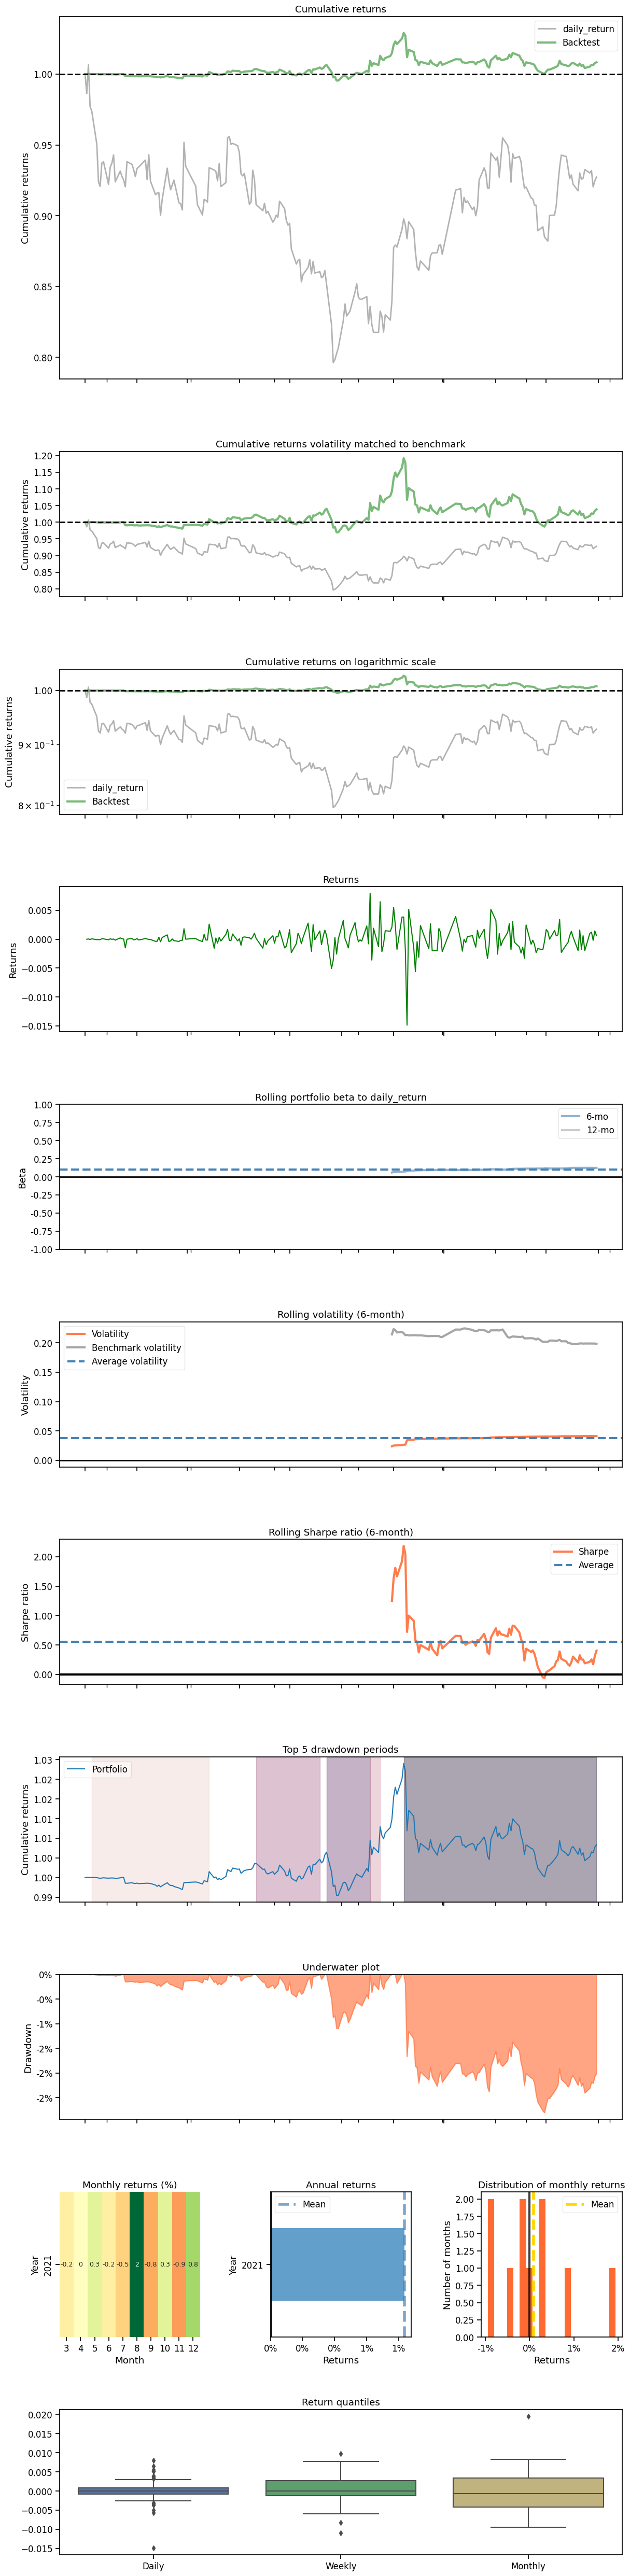

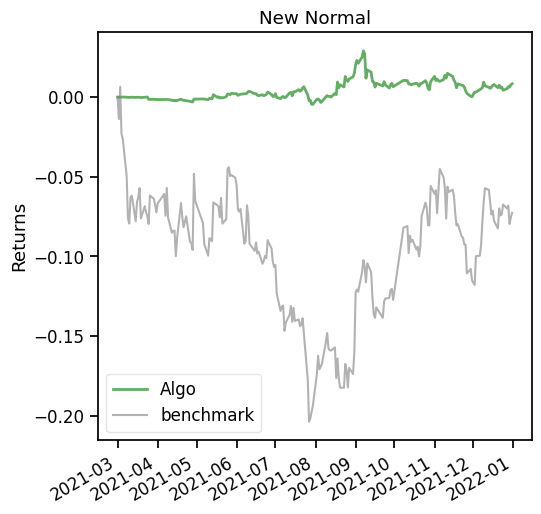

In [69]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print(df_account_value.loc[len(df_account_value)-1,'date'],df_account_value.loc[0,'date'])